### Creating the auxiliary input images

In [2]:
import os
import matplotlib.pyplot as plt
import rasterio
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from glob import glob

In [3]:
# Directories and Functions
os.makedirs("plots", exist_ok=True)
os.makedirs("models", exist_ok=True)

# 1. Load Data
def load_data(filepath):
    with rasterio.open(filepath) as src:
        values = src.read(1)  # Load the first band
        transform = src.transform
    return values, transform

# 2. Extract Sample-Centered Terrain Images
def extract_sample_centered_images(clor_gdf, values, transform, size=32):
    rows, cols = values.shape
    half_size = size // 2
    terrain_images = []

    for _, row in clor_gdf.iterrows():
        x, y = row["x"], row["y"]
        col, row = ~transform * (x, y)
        col, row = int(col), int(row)

        if 0 <= row-half_size < rows and 0 <= col-half_size < cols:
            img = values[row-half_size:row+half_size, col-half_size:col+half_size]
            if img.shape == (size, size):
                terrain_images.append(img)
            else:
                terrain_images.append(np.zeros((size, size)))  # Pad with zeros if out of bounds
        else:
            terrain_images.append(np.zeros((size, size)))  # Completely out of bounds

    return np.array(terrain_images)

In [4]:
clor = pd.read_csv(r"..\Data\dat07_u.csv")
quant = "Recharge mean mm/y"

# Drop NaNs for essential columns
clor = clor.dropna(subset=["lat", "lon", quant])


# Convert clor to a GeoDataFrame
geometry = [Point(xy) for xy in zip(clor['lon'], clor['lat'])]
clor_gdf = gpd.GeoDataFrame(clor, geometry=geometry, crs="EPSG:3577")  # WGS84 (lat/lon)



# # Extract the reprojected coordinates
clor_gdf['x'] = clor_gdf.geometry.x
clor_gdf['y'] = clor_gdf.geometry.y




# Use the updated coordinates

# 3. Load the recharge data
directory_path = r".\aux_inputs"
# List all .tif files in the directory
tif_files = glob(os.path.join(directory_path, "*.tif"))
# Create an empty list to store results
columns_list = []


for file_path in tif_files:
    print(f"Processing file: {file_path}")

    # Load the data
    values, transform = load_data(file_path)

    # Extract the centered images
    imgs_ann = extract_sample_centered_images(clor_gdf, values, transform)

    # Append the result to the list
    columns_list.append(imgs_ann)

all_imgs_ann = list(zip(*columns_list))

C:\Users\joept\AppData\Local\Temp\ipykernel_1320\2487286756.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  clor = pd.read_csv(r"..\Data\dat07_u.csv")


Processing file: .\aux_inputs\clay_raster_bound.tif
Processing file: .\aux_inputs\elevation_raster_bound.tif
Processing file: .\aux_inputs\ndvi_raster_bound.tif
Processing file: .\aux_inputs\PET_raster_bound.tif
Processing file: .\aux_inputs\rainfall_raster_bound.tif


In [5]:
## normalization of image values

all_imgs_ann_min = np.min(all_imgs_ann,axis=(0, 2, 3))
all_imgs_ann_max = np.max(all_imgs_ann,axis=(0, 2, 3))
imgs_ann_normalized = (all_imgs_ann - all_imgs_ann_min[None, :, None, None]) / (all_imgs_ann_max[None, :, None, None] - all_imgs_ann_min[None, :, None, None])



#### Checking the centered images

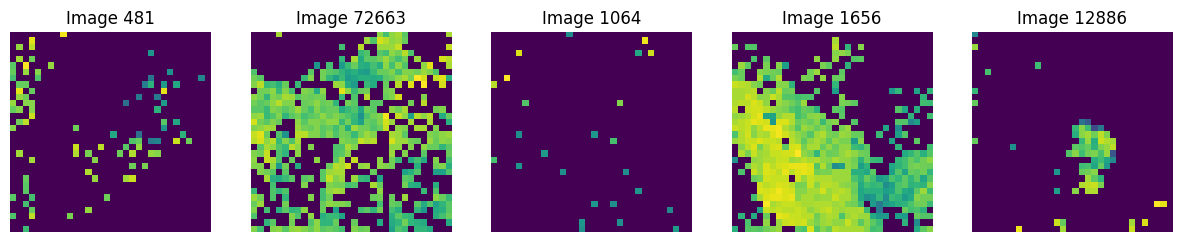

In [6]:
n = 5

# Select random images or specific indices
indices = np.random.choice(len(imgs_ann_normalized), n, replace=False)

# Plot the images
fig, axs = plt.subplots(1, n, figsize=(15, 5))
for i, idx in enumerate(indices):
    axs[i].imshow(imgs_ann_normalized[idx][0], cmap="viridis")
    axs[i].set_title(f"Image {idx}")
    axs[i].axis("off")
plt.show()

### Creating the location input

In [7]:
recharge_data = clor[['lat','lon','clay_perc','elevation_mahd','ndvi_avg','PET mm/y','distance_to_coast_km',
                      'soil_class','Rain mm/y','rainfall_seasonality','Recharge mean mm/y']]

recharge_data = clor[['lat','lon','clay_perc','elevation_mahd','ndvi_avg','PET mm/y','Rain mm/y', 'Recharge mean mm/y']]

# Calculate column means
recharge_data_mean = recharge_data.mean()

# Calculate column standard deviations
recharge_data_sd = recharge_data.std()


# Standardize the data (z-score normalization)
recharge_data_norm = ((recharge_data - recharge_data_mean) / recharge_data_sd).to_numpy()

# Standardize the data (min-max normalization)
recharge_data_min = recharge_data.min()
recharge_data_max = recharge_data.max()

recharge_data_norm = ((recharge_data - recharge_data_min) / (recharge_data_max - recharge_data_min)).to_numpy()

#location input

loc_ann = recharge_data_norm[:,0:-1]



### Our network

In [8]:
#packages

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Conv2D, Activation, SpatialDropout2D, GlobalAveragePooling2D, Flatten, Dense, Dropout, Concatenate, Lambda
from tensorflow.keras.initializers import HeNormal, Zeros
from tensorflow.keras.models import Model

In [9]:
# Use neural network to learn relationship between our parameters, their location and recharge ####

np.random.seed(321)
fold_size = recharge_data.shape[0] // 10

## splitting the dataset into test,val and train
test = np.random.choice(recharge_data.shape[0], fold_size, replace=False)
val = np.random.choice(np.setdiff1d(np.arange(recharge_data.shape[0]), test), fold_size, replace=False)
train = np.setdiff1d(np.arange(recharge_data.shape[0]), np.concatenate((test, val)))



# Data Preparation --------------------------------------------------------
## specify the total number of channels and the ones for which we have an auxiliary input

num_channels = 5
num_aux_available = 5


# Initialize the dictionary for inputs

conv_input_train = imgs_ann_normalized[train]  # Shape: (batch_size, num_channels, 32, 32, 1)
conv_input_train = conv_input_train.reshape((conv_input_train.shape[0], num_aux_available, 32, 32, 1))

aux_input_train = np.stack([loc_ann[train][:,[0,1,2]], loc_ann[train][:,[0,1,3]], loc_ann[train][:,[0,1,4]],
                           loc_ann[train][:,[0,1,5]],loc_ann[train][:,[0,1,6]]], axis=1) # Shape: (batch_size, num_aux_available, 3



x_train = [conv_input_train, aux_input_train]

conv_input_val = imgs_ann_normalized[val]  # Shape: (batch_size, num_channels, 32, 32, 1)
#conv_input_val = conv_input_train.reshape((conv_input_val.shape[0], num_aux_available, 32, 32, 1))

aux_input_val = np.stack([loc_ann[val][:,[0,1,2]], loc_ann[val][:,[0,1,3]], loc_ann[val][:,[0,1,4]],
                           loc_ann[val][:,[0,1,5]],loc_ann[val][:,[0,1,6]]], axis=1) # Shape: (batch_size, num_aux_available, 3

x_val = [conv_input_val, aux_input_val]

conv_input_test = imgs_ann_normalized[test]  # Shape: (batch_size, num_channels, 32, 32, 1)
#conv_input_test = conv_input_train.reshape((conv_input_test.shape[0], num_aux_available, 32, 32, 1))

aux_input_test = np.stack([loc_ann[test][:,[0,1,2]], loc_ann[test][:,[0,1,3]], loc_ann[test][:,[0,1,4]],
                           loc_ann[test][:,[0,1,5]],loc_ann[test][:,[0,1,6]]], axis=1) # Shape: (batch_size, num_aux_available, 3

x_test = [conv_input_test, aux_input_test]
#x_train[0] = x_train[0].reshape((x_train[0].shape[0], 32, 32, 1))
#x_val[0] = x_val[0].reshape((x_val[0].shape[0], 32, 32, 1))
#x_test[0] = x_test[0].reshape((x_test[0].shape[0], 32, 32, 1))


y_train = recharge_data_norm[:,7].astype(float)[train]
y_val = recharge_data_norm[:,7].astype(float)[val]
y_test = recharge_data_norm[:,7].astype(float)[test]

 In the next cell the architecture of the model is defined. The model is a multi-channels version of the one used in *Kirkwood et. al* and it contains hybrid channels, which can either take both location and auxiliary inputs or only location when images are not available. With *num_aux_available* in the code cell before, you specify the number of the hybrid channels. 

In [10]:
# Defining Model ----------------------------------------------------------
time = tf.timestamp()

dropratespat = 0.5  # match what model was trained with
dropratedense = 0.2  # match what model was trained with

kernel_ini = HeNormal()
bias_ini = Zeros()
# Define combined inputs

conv_input = Input(shape=(num_aux_available, 32, 32, 1), name='conv_input')  # Multiple channels
aux_input = Input(shape=(num_channels, 3), name='aux_input')            # Multiple channels

# Placeholder for conv_output
conv_output_placeholder = Lambda(lambda x: tf.zeros((tf.shape(x)[0], 128)))(conv_input)

# Split and process each channel
channel_outputs = []
for i in range(num_channels):
    channel_aux_input = Lambda(lambda x: x[:, i])(aux_input)  # Shape: (batch_size, 3)
    auxiliary_output = Dense(1920, kernel_initializer=kernel_ini, bias_initializer=bias_ini)(channel_aux_input)
    auxiliary_output = Activation("relu")(auxiliary_output)
    auxiliary_output = Dropout(rate=dropratedense)(auxiliary_output)
    auxiliary_output = Flatten()(auxiliary_output)
    
    if i < num_aux_available:
        # Extract channel-specific inputs
        channel_conv_input = Lambda(lambda x: x[:, i, :, :, :])(conv_input)
        conv_output = Conv2D(128, (3, 3), dilation_rate=1, strides=3, kernel_initializer=kernel_ini, bias_initializer=bias_ini)(channel_conv_input)
        conv_output = Activation("relu")(conv_output)
        conv_output = SpatialDropout2D(rate=dropratespat)(conv_output)

        conv_output = Conv2D(128, (3, 3), dilation_rate=1, strides=1, kernel_initializer=kernel_ini, bias_initializer=bias_ini)(conv_output)
        conv_output = Activation("relu")(conv_output)
        conv_output = SpatialDropout2D(rate=dropratespat)(conv_output)

        conv_output = Conv2D(128, (3, 3), dilation_rate=1, strides=1, kernel_initializer=kernel_ini, bias_initializer=bias_ini)(conv_output)
        conv_output = Activation("relu")(conv_output)
        conv_output = SpatialDropout2D(rate=dropratespat)(conv_output)

        conv_output = Conv2D(128, (3, 3), dilation_rate=1, strides=1, kernel_initializer=kernel_ini, bias_initializer=bias_ini)(conv_output)
        conv_output = Activation("relu")(conv_output)
        conv_output = SpatialDropout2D(rate=dropratespat)(conv_output)

        conv_output = GlobalAveragePooling2D()(conv_output)
        conv_output = Flatten()(conv_output)

        # Combine the outputs
        channel_output = Concatenate()([conv_output, auxiliary_output])
    else:
        # Storing only the auxiliary output
        channel_output = Concatenate()([conv_output_placeholder, auxiliary_output])
    
    # Append the output for this channel after it is defined in both branches
    channel_outputs.append(channel_output)


# Combine all channel outputs
main_output = Concatenate()(channel_outputs)

# Dense layers for final output
main_output = Dense(1024, kernel_initializer=kernel_ini, bias_initializer=bias_ini)(main_output)
main_output = Activation("relu")(main_output)
main_output = Dropout(rate=dropratedense)(main_output)
main_output = Dense(256, kernel_initializer=kernel_ini, bias_initializer=bias_ini)(main_output)
main_output = Activation("relu")(main_output)
main_output = Dropout(rate=dropratedense)(main_output)
main_output = Dense(units=2, activation="linear", name="dist_param", kernel_initializer=kernel_ini, bias_initializer=bias_ini)(main_output)
main_output = tf.keras.layers.Lambda(lambda x: tf.random.normal(shape=tf.shape(x[:, 0:1]), mean=x[:, 0:1], stddev=1e-3 + tf.nn.softplus(0.1 * x[:, 1:2])))(main_output)

# Define the model
model = Model(inputs=[conv_input, aux_input], outputs=main_output, name="MultichannelModel")
model.summary()

c:\Users\joept\miniconda3\envs\tf\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "MultichannelModel"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 conv_input (InputLayer)        [(None, 5, 32, 32,   0           []                               
                                1)]                                                               
                                                                                                  
 lambda_2 (Lambda)              (None, 32, 32, 1)    0           ['conv_input[0][0]']             
                                                                                                  
 lambda_4 (Lambda)              (None, 32, 32, 1)    0           ['conv_input[0][0]']             
                                                                                                  
 lambda_6 (Lambda)              (None, 32, 32, 1)    0           ['conv_input[0][0

In [11]:
Concatenate()([conv_output, auxiliary_output])

<KerasTensor: shape=(None, 2048) dtype=float32 (created by layer 'concatenate_6')>

In [12]:
print(conv_input.shape) 

(None, 5, 32, 32, 1)


In [13]:
# Define the model
model = models.Model(inputs=[conv_input, aux_input], outputs=main_output)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='mean_squared_error' # Adjust loss function as needed
              )

# Summary of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 conv_input (InputLayer)        [(None, 5, 32, 32,   0           []                               
                                1)]                                                               
                                                                                                  
 lambda_2 (Lambda)              (None, 32, 32, 1)    0           ['conv_input[0][0]']             
                                                                                                  
 lambda_4 (Lambda)              (None, 32, 32, 1)    0           ['conv_input[0][0]']             
                                                                                                  
 lambda_6 (Lambda)              (None, 32, 32, 1)    0           ['conv_input[0][0]']         

 conv2d_8 (Conv2D)              (None, 10, 10, 128)  1280        ['lambda_6[0][0]']               
                                                                                                  
 conv2d_12 (Conv2D)             (None, 10, 10, 128)  1280        ['lambda_8[0][0]']               
                                                                                                  
 conv2d_16 (Conv2D)             (None, 10, 10, 128)  1280        ['lambda_10[0][0]']              
                                                                                                  
 activation_1 (Activation)      (None, 10, 10, 128)  0           ['conv2d[0][0]']                 
                                                                                                  
 activation_6 (Activation)      (None, 10, 10, 128)  0           ['conv2d_4[0][0]']               
                                                                                                  
 activatio

In [14]:
#checking for nan's
contains_nan = np.isnan(imgs_ann).any()
print("Contains NaN:", contains_nan)

Contains NaN: False


In [15]:
#checking if GPU is available for training

if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")

GPU is available


In [37]:
# Training ----------------------------------------------------------------
# Set batch size and number of epochs
batch_size = 100
epochs = 75

# Train the model with the specified parameters
history = model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    shuffle=True,
    verbose=2
    # Uncomment the following lines to use callbacks for early stopping and model checkpointing
    # callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200),
    #            tf.keras.callbacks.ModelCheckpoint(monitor='val_loss', save_best_only=True, save_weights_only=True,
    #                                              filepath=os.path.join(os.getcwd(), "models/modelweights.hdf5"))]
)

# Find the minimum validation loss
min_val_loss = min(history.history['val_loss'])

# Note: Python does not have a direct equivalent of R's Sys.time() - time
# You would need to manually track the start and end time using datetime or time module

# Find the epoch with the minimum validation loss
best_epoch = history.history['val_loss'].index(min_val_loss)

# Save and load model weights
model.save_weights(os.path.join(os.getcwd(), "models/modelweights.hdf5"))
model.load_weights(os.path.join(os.getcwd(), "models/modelweights.hdf5"))

# Create a new model for predictions using the 'dist_param' layer
meanmodel = tf.keras.Model(
    inputs=model.input,
    outputs=model.get_layer("dist_param").output
)

# Save and load the mean model
meanmodel.save(os.path.join(os.getcwd(), "models/meanmodel"))
meanmodel = tf.keras.models.load_model(os.path.join(os.getcwd(), "models/meanmodel"))

# Create a DataFrame for holdout predictions and observations
holdout = pd.DataFrame({'obs': y_test, 'preds': meanmodel.predict(x_test)[:, 0]})

# Calculate and print R squared and RMSE
print(f"R squared = {round(np.corrcoef(holdout['preds'], holdout['obs'])[0, 1]**2, 3)}")
print(f"RMSE = {round(np.sqrt(np.mean((holdout['preds'] - holdout['obs'])**2)), 3)}")


Epoch 1/75
789/789 - 27s - loss: 6.5673e-04 - val_loss: 8.8374e-04 - 27s/epoch - 34ms/step
Epoch 2/75
789/789 - 20s - loss: 6.6751e-04 - val_loss: 8.6593e-04 - 20s/epoch - 26ms/step
Epoch 3/75
789/789 - 20s - loss: 6.6144e-04 - val_loss: 8.6498e-04 - 20s/epoch - 25ms/step
Epoch 4/75
789/789 - 20s - loss: 6.6306e-04 - val_loss: 8.7496e-04 - 20s/epoch - 25ms/step
Epoch 5/75
789/789 - 19s - loss: 6.5646e-04 - val_loss: 8.7415e-04 - 19s/epoch - 24ms/step
Epoch 6/75
789/789 - 20s - loss: 6.7481e-04 - val_loss: 8.6413e-04 - 20s/epoch - 25ms/step
Epoch 7/75
789/789 - 20s - loss: 6.5862e-04 - val_loss: 8.6440e-04 - 20s/epoch - 25ms/step
Epoch 8/75
789/789 - 20s - loss: 6.5689e-04 - val_loss: 8.7501e-04 - 20s/epoch - 25ms/step
Epoch 9/75
789/789 - 20s - loss: 6.6315e-04 - val_loss: 8.6775e-04 - 20s/epoch - 25ms/step
Epoch 10/75
789/789 - 20s - loss: 6.5858e-04 - val_loss: 8.9572e-04 - 20s/epoch - 25ms/step
Epoch 11/75
789/789 - 20s - loss: 6.6105e-04 - val_loss: 8.7421e-04 - 20s/epoch - 26ms/st

INFO:tensorflow:Assets written to: c:\Users\joept\OneDrive\Bureaublad\CEGM2003\Project\CEGM2003-Water\New model\CNN_from_R\models/meanmodel\assets


INFO:tensorflow:Assets written to: c:\Users\joept\OneDrive\Bureaublad\CEGM2003\Project\CEGM2003-Water\New model\CNN_from_R\models/meanmodel\assets
c:\Users\joept\miniconda3\envs\tf\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


308/308 [==============================] - 7s 19ms/step
R squared = 0.718
RMSE = 0.028


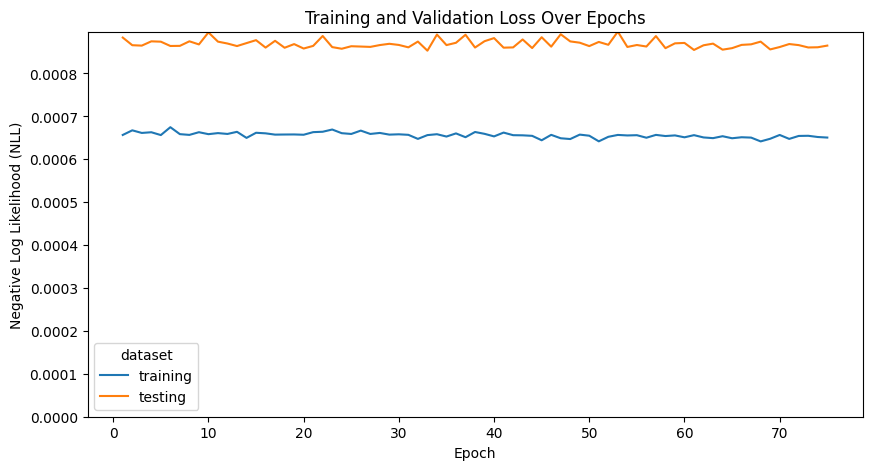

In [38]:
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

# Prepare training history data for plotting
trainhist = pd.DataFrame(history.history)[['loss', 'val_loss']]
trainhist.columns = ['training', 'testing']
trainhist['epoch'] = range(1, len(trainhist) + 1)

# Melt the training history data for plotting
trainhist_melted = trainhist.melt(id_vars='epoch', var_name='dataset', value_name='NLL')

# Plot training and validation loss over epochs
plt.figure(figsize=(10, 5))
sns.lineplot(x='epoch', y='NLL', hue='dataset', data=trainhist_melted)
plt.ylim(0, trainhist['testing'].quantile(0.999))
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Negative Log Likelihood (NLL)')
plt.show()

(0.0, 0.00086162646766752)

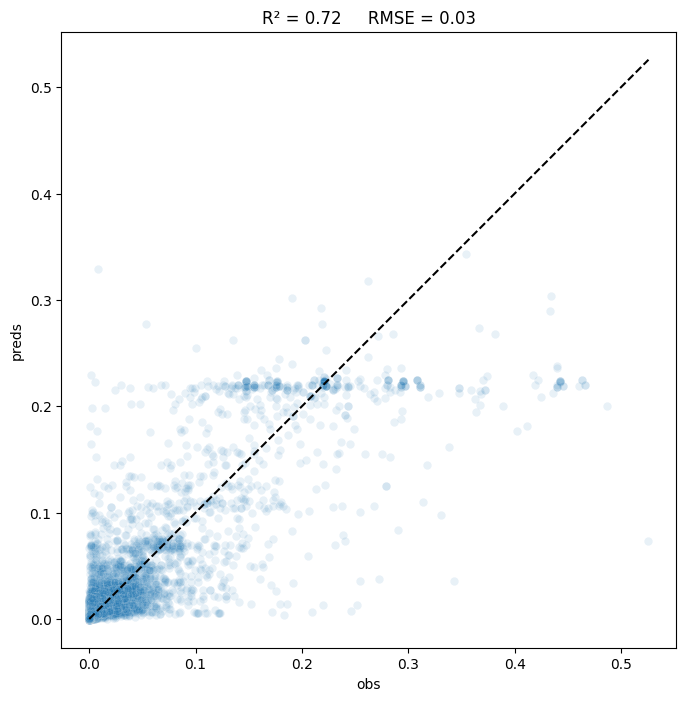

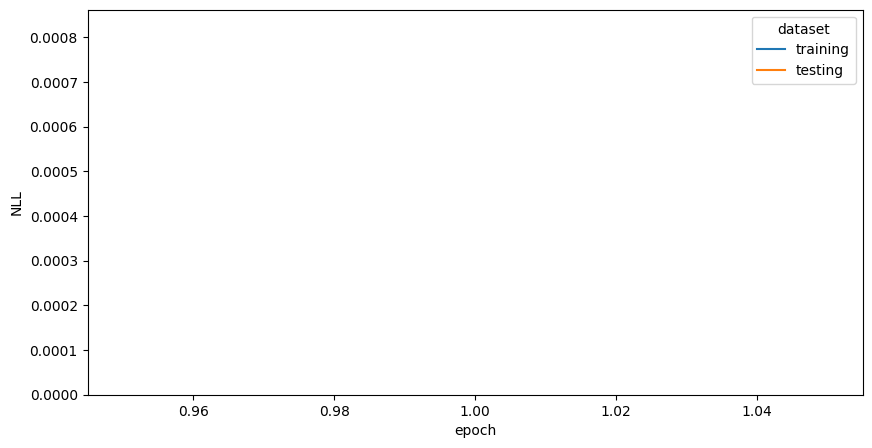

In [32]:
# Plot observed vs predicted values
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 8))
sns.scatterplot(x='obs', y='preds', data=holdout, alpha=0.1)
plt.plot([holdout['obs'].min(), holdout['obs'].max()], [holdout['obs'].min(), holdout['obs'].max()], 'k--')
# plt.xlabel(f"Observed log({elem})" if logtrans else f"observed {elem}")
# plt.ylabel(f"Predicted log({elem})" if logtrans else f"predicted {elem}")
plt.title(f"R² = {round(np.corrcoef(holdout['preds'], holdout['obs'])[0, 1]**2, 2)}     RMSE = {round(np.sqrt(np.mean((holdout['preds'] - holdout['obs'])**2)), 2)}")
plt.gca().set_aspect('equal', adjustable='box')
# plt.savefig(f"plots/{elem}_mean_holdout_{round(np.corrcoef(holdout['preds'], holdout['obs'])[0, 1]**2, 2)*100}.png", dpi=300)

# Prepare training history data for plotting
trainhist = pd.DataFrame(history.history)[['loss', 'val_loss']]
trainhist.columns = ['training', 'testing']
trainhist['epoch'] = range(1, len(trainhist) + 1)

# Melt the training history data for plotting
trainhist_melted = trainhist.melt(id_vars='epoch', var_name='dataset', value_name='NLL')

# Plot training and validation loss over epochs
plt.figure(figsize=(10, 5))
sns.lineplot(x='epoch', y='NLL', hue='dataset', data=trainhist_melted)
plt.ylim(0, trainhist['testing'].quantile(0.999))
# plt.savefig(f"plots/{elem}_training_{round(np.corrcoef(holdout['preds'], holdout['obs'])[0, 1]**2, 2)*100}.png", dpi=300)
